# Homework 6: Dimensionality Reduction (100 points)

In this homework, you will be implementing Principal Component Analysis (PCA) and K-means clustering from scratch in python using NumPy.

In [1]:
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from numpy.random import uniform
from sklearn.datasets import make_blobs
import seaborn as sns
import random
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import random

# Load Data

Load train and test data for the Fashion MNIST dataset using PyTorch.

In [3]:
data_dimension  = 28*28   # images are 28x28 pixels
num_classes = 10      # there are 10 classes

train_dataset = datasets.FashionMNIST(
    root="data_fashion",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

# Download test data from open datasets.
test_dataset = datasets.FashionMNIST(
    root="data_fashion",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

## Part A: Subsampling from the dataset

In this part, you must subsample the train and test set such both contain 1000 images, with 100 images from each of the 10 classes. Also store the labels for each image.

In [4]:
def getLabelLoader(label:int,size:int):
    x = train_dataset.targets.clone().detach()
    idx = x == label
    train_indices = idx.nonzero().reshape(-1)
    train_subset = Subset(train_dataset, train_indices)
    train_dataloader = DataLoader(train_subset, shuffle=True, batch_size=size)
    return train_dataloader

In [5]:
def flatten(t):
    t = t.reshape(1, -1)
    t = t.squeeze()
    return t

In [6]:
images_per_class = 100

# Create a new dataset with only 100 images per class and with a total of 1000 images
def create_subset(dataset, images_per_class):
    """
    Create a dataset with only a given number of images per class.

    Args:
        dataset: The original dataset
        images_per_class: The number of images per class to keep
    
    Returns:
        images: A numpy array of shape (num_classes * images_per_class, data_dimension)
        labels: A numpy array of shape (num_classes * images_per_class,)
    """
    images, labels = [], []
    
    # WRITE YOUR CODE HERE
    for i in range(10):
        for j in range(100):
            loader=getLabelLoader(i,1)
            sample = next(iter(loader))
            image,label=sample[0],sample[1]
            image=flatten(image)
            image=image.cpu().detach().numpy()
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Train and test data
train_images, train_labels = create_subset(train_dataset, images_per_class)
test_images, test_labels = create_subset(test_dataset, images_per_class)

/var/folders/qk/rr869dkj11v2ndc3b68t2_2c0000gn/T/ipykernel_74816/1589232340.py:28: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(images), np.array(labels)
/var/folders/qk/rr869dkj11v2ndc3b68t2_2c0000gn/T/ipykernel_74816/1589232340.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(images), np.array(labels)


### Plot grid of images

You must complete the `plot_grid` function defined below. A sample image of the plot has been provided with the homework (see `sample_output_grid.png`).

/var/folders/qk/rr869dkj11v2ndc3b68t2_2c0000gn/T/ipykernel_74816/1913136526.py:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_classes,num_images_per_class,res[labels[i]]+1+10*labels[i])


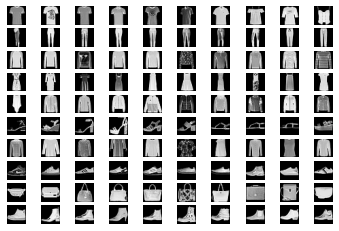

In [7]:
def plot_grid(images, labels, num_classes, num_images_per_class):
    """
    Plot a grid of images of shape num_classes x images_per_class. Each row must 
    contain the images belonging to an unique class.

    Args:
        images: A numpy array of shape (num_classes * images_per_class, data_dimension)
        labels: A numpy array of shape (num_classes * images_per_class,)
        num_classes: The number of classes
        num_images_per_class: The number of images per class to be displayed
    
    Hint: Use plt.subplot to plot the images in a grid.
    """
    # WRITE YOUR CODE HERE
    res=10*[0]
    images=images.reshape(1000,28,28)
    for i in range(len(labels)):
        if res[labels[i]]<10:
            plt.subplot(num_classes,num_images_per_class,res[labels[i]]+1+10*labels[i])
            plt.imshow(images[i].squeeze(),cmap='gray')
            plt.axis('off')
            res[labels[i]]+=1
    
    
plot_grid(train_images, train_labels, num_classes, 10)

# Part B: Principal Component Analysis (PCA)

Perform principal component analysis (PCA) on the train dataset to reduce the data dimension from `784` to `100`.

In [8]:
def zeroMean(data):      
    meanVal=np.mean(data,axis=0)    
    newData=data-meanVal
    return newData,meanVal

In [9]:
def PCA(X , num_components):
    """
    Function to perform PCA on the dataset X.

    Args:
        X: A numpy array of shape (num_samples, data_dimension)
        num_components: The number of principal components to keep

    Returns:
        X_reduced: A numpy array of shape (num_samples, num_components). The represents the reduced data.
        X_reconstructed: A numpy array of shape (num_samples, data_dimension). The represents the reconstructed data from the reduced data.
    """
    # WRITE YOUR CODE HERE
    newData,meanVal=zeroMean(X)
    covMar=np.cov(newData,rowvar=0)   
    eigVals,eigVects=np.linalg.eig(np.mat(covMar))
    eigValIndice=np.argsort(eigVals)          
    n_eigValIndice=eigValIndice[-1:-(num_components+1):-1]   
    n_eigVect=eigVects[:,n_eigValIndice]       
    X_reduced = newData*n_eigVect               
    X_reconstructed = (X_reduced*n_eigVect.T)+meanVal 
     
    return X_reduced, X_reconstructed

In [10]:
pca_dimension = 100
train_images_pca, reconstruction = PCA(train_images, pca_dimension)


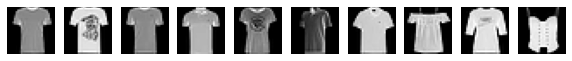

In [11]:
# Visualize the original images
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

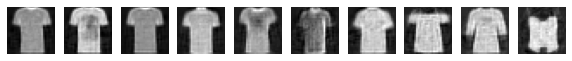

In [12]:
# Visualize the reconstructed images
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(reconstruction[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

The reconstructed images must look similar to the original input images.

# Part C: KMeans Clustering

In this part, you will be clustering the train images that had been reduced to 100 dimensions using PCA into `10 clusters`.

In [13]:
def euclidean(point, data):
    """
    Euclidean distance between point & data.
    Point has dimensions (m,), data has dimensions (n,m), and output will be of size (n,).

    Args:
        point: A numpy array of shape (m,)
        data: A numpy array of shape (n,m)

    Returns:
        A numpy array of shape (n,) containing the euclidean distance between point and each row of data.
    """
    # WRITE YOUR CODE HERE
    return np.sqrt(np.sum((point - data)**2, axis=1))

class KMeans:
    """
    Class to perform K-Means clustering.
    """
    def __init__(self, n_clusters=8, max_iter=300):
        """
        Args:
            n_clusters: The number of clusters
            max_iter: The maximum number of iterations to run the algorithm for
        
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
    
    def init_centroids(self, X):
        """
        Initialize the centroids by randomly sampling from the dataset. Store the computed
        centroids in self.centroids.

        Args:
            X: A numpy array of shape (num_samples, data_dimension)
        
        Hint: Initialize the centroids such that when a random datapoint is selected as the first, 
              the rest are initialized w/ probabilities proportional to their distances to the first.
              You may use argument `p` in np.random.choice to do this.
        """
        # WRITE YOUR CODE HERE
        self.centroids = [random.choice(X)]
        
    def fit(self, X_train):
        """
        Train the K-Means model on the dataset X_train.

        Args:
            X_train: A numpy array of shape (num_samples, data_dimension)

        Hint: 
            (1) Use the euclidean function defined above. 
            (2) Run the algorithm for a maximum of self.max_iter iterations.
            (3) Initialize the centroids before running the clustering algorithm.
        """
        # WRITE YOUR CODE HERE
        self.init_centroids(X_train)
        for _ in range(self.n_clusters-1):
            distans = np.sum([euclidean(centroid, X_train) for centroid in self.centroids], axis=0)
            distans /= np.sum(distans)
            new_centroid_idx, = np.random.choice(range(len(X_train)), size=1, p=distans)
            self.centroids += [X_train[new_centroid_idx]]

        ite = 0
        prev_centroids = None
        while np.not_equal(self.centroids, prev_centroids).any() and ite < self.max_iter:
            sorted_points = [[] for _ in range(self.n_clusters)]
            for x in X_train:
                dists = euclidean(x, self.centroids)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)
            prev_centroids = self.centroids
            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():  
                    self.centroids[i] = prev_centroids[i]
            ite += 1


    def evaluate(self, X):
        """
        Function to evaluate the K-Means model on the dataset X.

        Args:
            X: A numpy array of shape (num_samples, data_dimension)
        
        Returns:
            centroids: A numpy array of shape (n_clusters, data_dimension) containing the centroids of the clusters.
            centroid_idxs: A numpy array of shape (num_samples,) containing the cluster labels for each sample in X.
        """
        centroids, centroid_idxs = [], []

        # WRITE YOUR CODE HERE
        for x in X:
            dists = euclidean(x, self.centroids)
            centroid_idx = np.argmin(dists)
            centroids.append(self.centroids[centroid_idx])
            centroid_idxs.append(centroid_idx)
        return centroids, centroid_idxs

In [20]:
kmeans = KMeans(n_clusters=10)
train_images_pca = StandardScaler().fit_transform(train_images_pca)

kmeans.fit(train_images_pca)

# View results
class_centers, classification = kmeans.evaluate(train_images_pca)

### Plot mean image for each cluster

The KMeans clustering algorithm provides you with 10 clusters, with each cluster containing a set of images. In this part, you must compute the mean image for each cluster and plot it as a grid with 10 images such that each image corresponds to the mean image of a cluster. By mean image of a cluster, we imply the mean of the images contained in the cluster.

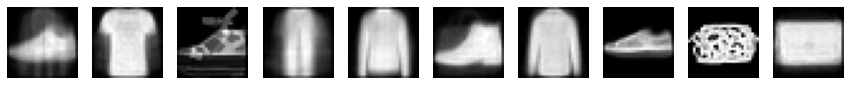

In [23]:
# Plot grid of cluster images from each class

# WRITE YOUR CODE HERE
plt.figure(figsize=(15,15))
im={}
for i in range(len(classification)):
    if classification[i] not in im.keys():
        im[classification[i]]=[train_images[i]]
    else:
        im[classification[i]].append(train_images[i])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(np.mean(im[i],axis=0).reshape(28,28),cmap='gray')
    plt.axis('off')

### Plot grid containing 10 images for each cluster

In this part, you must plot a grid of images of size `number of cluster x 10` with each row corresponding to a unique cluster and all columns corresponding to a row comprise 10 samples from the cluster that the row represents.

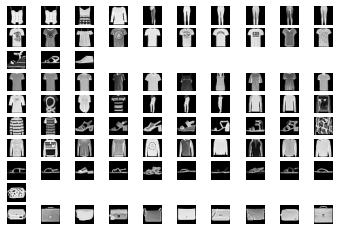

In [22]:
# Plot 10 images from each cluster for each class

# WRITE YOUR CODE HERE
res=10*[0]
for i in range(len(classification)):
    train_images_reshape=train_images[i].reshape(28,28)
    if res[classification[i]]<10:
        plt.subplot(num_classes,10,res[classification[i]]+1+10*classification[i])
        plt.imshow(train_images_reshape.squeeze(),cmap='gray')
        plt.axis('off')
        res[classification[i]]+=1

# Extra Credit: k-Nearest Neighbor (KNN) classification (25 points)

In this section, you are supposed to perform k-Nearest Neighbor classification on the test data and find the optimal value of `k` for which the model outputs the highest classification accuracy.

In [17]:
def most_common(lst):
    '''Returns the most common element in a list. If there is a tie, returns the 
    element occuring first in the list.'''
    # WRITE YOUR CODE HERE
    return max(set(lst),key=lst.count)


class KNearestNeighborsClassifier():
    """
    Class to perform K-Nearest Neighbors classification.
    """
    def __init__(self, k=5, dist_metric=euclidean):
        """
        Args:
            k: The number of nearest neighbors to use for classification
            dist_metric: The distance metric to use for classification. (Default: euclidean)
        """
        self.k = k
        self.dist_metric = dist_metric

    def fit(self, X_train, y_train):
        """
        Function to train the K-Nearest Neighbors classifier on the train dataset.

        Args:
            X_train: A numpy array of shape (num_samples, data_dimension) containing the training data.
            y_train: A numpy array of shape (num_samples,) containing the training labels.
        """
        # WRITE YOUR CODE HERE
        self.X_train = X_train
        self.y_train = y_train
       
       

    def predict(self, X_test):
        """
        Predict the labels for the test dataset.

        Args:
            X_test: A numpy array of shape (num_samples, data_dimension) containing the test data.

        Returns:
            y_pred: A numpy array of shape (num_samples,) containing the predicted labels for the test data.

        Hint: Use the self.dist_metric function to compute the distance between the test data and the training data.
              For each sample, choose the most common label among the k nearest neighbors.
        """
        # WRITE YOUR CODE HERE

        neigh= []
        for x in X_test:
            dists = self.dist_metric(x, self.X_train)
            y_sorted = [y for _, y in sorted(zip(dists, self.y_train))]
            neigh.append(y_sorted[:self.k])
        return list(map(most_common, neigh))
    
    def evaluate(self, X_test, y_test):
        """
        Evaluate the K-Nearest Neighbors classifier on the test dataset.

        Args:
            X_test: A numpy array of shape (num_samples, data_dimension) containing the test data.
            y_test: A numpy array of shape (num_samples,) containing the test labels.

        Returns:
            accuracy: A float value between 0 and 1 representing the accuracy of the classifier.
        """
        # WRITE YOUR CODE HERE
        
        y_pred = self.predict(X_test)
        accu = sum(y_pred == y_test) / len(y_test)
        return accu
    

/var/folders/qk/rr869dkj11v2ndc3b68t2_2c0000gn/T/ipykernel_74816/733745917.py:71: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  accu = sum(y_pred == y_test) / len(y_test)
/var/folders/qk/rr869dkj11v2ndc3b68t2_2c0000gn/T/ipykernel_74816/733745917.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  accu = sum(y_pred == y_test) / len(y_test)


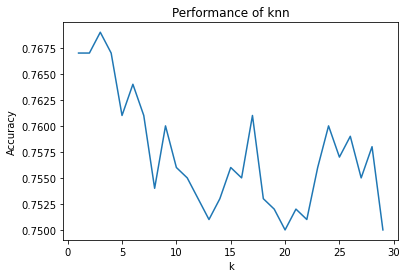

In [18]:
# Evaluate KNN classifier for k varying from 1 to 30 and plot the accuracy
accuracies = []
ks = range(1, 30)
for k in ks:
    knn = KNearestNeighborsClassifier(k=k)
    knn.fit(train_images, train_labels)
    accuracy = knn.evaluate(test_images, test_labels)
    accuracies.append(accuracy)
fig, ax = plt.subplots()
ax.plot(ks, accuracies)
ax.set(xlabel="k",
       ylabel="Accuracy",
       title="Performance of knn")
plt.show()

### Report the k for which you get the highest accuracy on the test dataset.

In general, the accuracy decreases as the value of k increases. For this test dataset, k=3 has the highest accuracy, which is higher than 0.7675.